In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import umap.umap_ as umap

2024-05-28 23:59:01.720235: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 23:59:01.739887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 23:59:01.884300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 23:59:01.885163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 23:59:02.483580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Importing the USG-ground-based comparison data for large bolides and cleaning up the CSV file:

In [2]:
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison/usg-ground-based-comparison_EDITED.csv', sep = ',', skip_blank_lines=True).iloc[2:-3]  
# skip the first two rows after header and the last three rows since those are garbage

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()

/tmp/ipykernel_213102/913176734.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
/tmp/ipykernel_213102/913176734.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
/tmp/ipykernel_213102/913176734.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')


Drop Queensland for now as it doesn't have LC (needed for duration and peak/integrated intensities)

In [3]:
usg_ground_based_comparison.drop(usg_ground_based_comparison[usg_ground_based_comparison['Event'] == 'Queensland'].index, inplace=True)

Sort DataFrame alphabetically by the event name (to match the order in which csvs are read from the `event` directory and its subdirectories) in-place:

In [4]:
usg_ground_based_comparison.sort_values('Event', inplace=True)

Note that all parameters (e.g. azimuth, zenith angle, speed, height) in the `usg_ground_based_comparison` dataframe are the USG-reported data rather than ground-based. The LCs (with intensity and magnitude measurements) for all events **other than Chelyabinsk** are also USG LCs; Chelyabinsk instead uses ground-based data

Now plotting speed difference and radiant difference against speed, recreating Figs. $2$ and $3$ of Brown and Borovicka:

In [5]:
# usg_ground_based_comparison = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison[['DV', 'Radiant Diff']], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_dv = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['DV'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_drad = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['Radiant Diff'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')

# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height, Begin Height, End Height, Length to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height', 'Begin Height (km)', 'End Height (km)', 'Length (km)']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# convert date to datetime object
usg_ground_based_comparison['Date'] = pd.to_datetime(usg_ground_based_comparison['Date'])

# usg speed, dv, drad
usg_speed = usg_ground_based_comparison['Speed']
dv = usg_ground_based_comparison['DV']
drad = usg_ground_based_comparison['Radiant Diff']

Fig. $2$ of B&B:

(Text(0.5, 0, 'Speed (km/s)'), Text(0, 0.5, 'Speed difference (km/s)'))

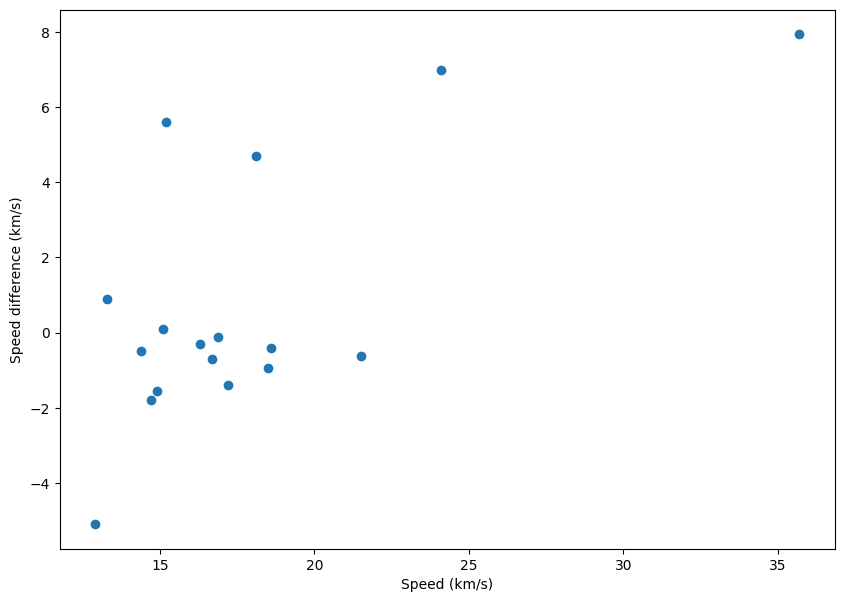

In [6]:
plt.figure(figsize = (10, 7))
plt.scatter(usg_speed, dv)
plt.xlabel('Speed (km/s)'), plt.ylabel('Speed difference (km/s)')

Fig. $3$ of B&B:

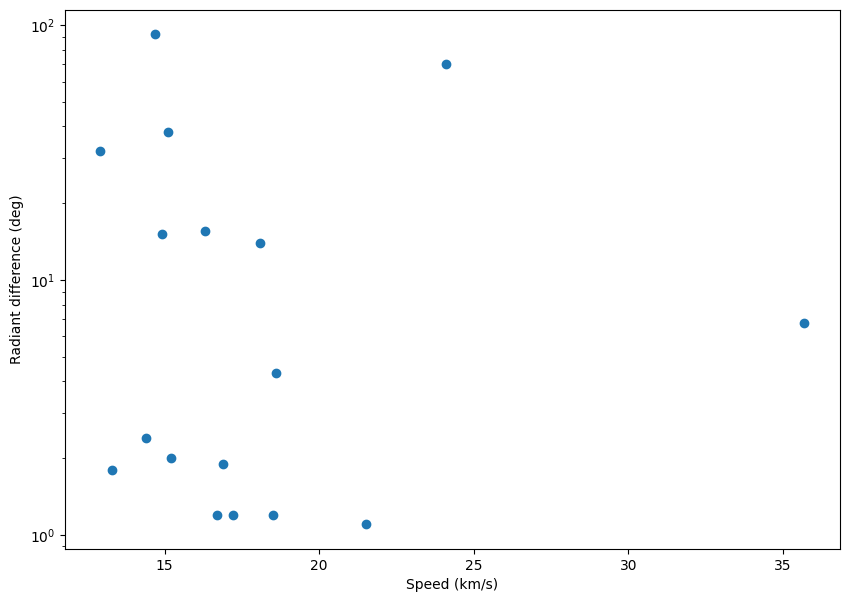

In [7]:
plt.figure(figsize = (10, 7))
# note that we use the usg reported speed (which is in our processed df) rather tahn the ground based speed (which we dropped earlier)
plt.scatter(usg_speed,drad)
plt.xlabel('Speed (km/s)'), plt.ylabel('Radiant difference (deg)')
plt.yscale('log')  # log y scale following B&B

Now plotting speed difference and radiant difference against peak intensity and lightcurve duration (from the LC data):

Get all intensity and magnitude `.csv` files for all the events (check all subdirectories of 'events') for `.csv` files, then sort to make sure they are in alphabetical order by event folder name:

In [8]:
# should get all the intensity and magnitude files in the event folder name
int_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_INT.csv'))]
mag_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_MAG.csv'))]
# sort lists alphabetically, by the event folder name
int_files.sort()
mag_files.sort()

Define functions to get the peak intensities and lightcurve durations from the LC data:

In [9]:
def get_peak_intensity(intensity_csv_path):
    """
    Gets the peak intensity of a fireball event from an intensity CSV generated by the CNEOS_LC_INT_MAY-format.py script, 
    given the path 'intensity_csv_path' to the event

    param str: intensity_csv_path: file path to the intensity CSV for the fireball event

    return float: returns peak intensity value as a float
    """
    intensity_df = pd.read_csv(intensity_csv_path, header=None, names=['Time (s)', 'Intensity (W/sr)'])  # reading intensity data
    return np.float64(intensity_df['Intensity (W/sr)'].max())  # get the maximum intensity 
    
def get_lightcurve_duration(magnitude_csv_path, noise_threshold=-17.):
    """
    Gets the lightcurve duration of a fireball event from a magnitude CSV generated by the CNEOS_LC_INT_MAY-format.py script, given the path
    'magnitude_csv_path' to the event

    param str magnitude_csv_path: file path to the magnitude CSV for the fireball event
    default param float noise_threshold: noise threshold (anything below this is considered noise rather than a possible LC signal); 
    set to -17 by default

    return float duration: returns lightcurve duration as a float
    """
    # get the csv data, coerce any non numeric values to nans
    magnitude_df = pd.read_csv(magnitude_csv_path, header=None, names=['Time (s)', 'Bolometric Magnitude']).apply(pd.to_numeric, errors='coerce')
    # replace all nas with infinity, because np.inf < noise_threshold always evaluates to False (which we want)
    magnitude_df.fillna(np.inf, inplace=True)
    # get all indices for which the bolometric magnitude is less than the noise threshold
    # (this is the actual light curve as anything below (greater than) that is noise)
    filtered_magnitude_df = magnitude_df['Bolometric Magnitude'] < noise_threshold
    # generate the dataframe for cumulative summation to detect changes from False to True in the column and vice versa
    cumsum_df = filtered_magnitude_df != filtered_magnitude_df.shift()
    # create dataframe with the count, start and end times of every consecutive sequence of either 'True' or 'False' in the data
    start_end_time_df = magnitude_df.groupby(cumsum_df.cumsum()).agg({'Time (s)': ['count', 'min', 'max']}).reset_index()
    start_end_time_df.columns = start_end_time_df.columns.droplevel()
    # take the actual light curve to be the longest consecutive sequence of "True" in the data (consecutive sequence of values less than
    # -17 bolometric magnitude)
    # if first sequence is noise (below noise threshold), remove every other sequence starting with the first one, 
    # since the df alternates noise-signal-noise-signal etc
    # otherwise remove every other sequence starting with the second one since the df alternates signal-noise-signal-noise etc.
    # print(magnitude_df['Bolometric Magnitude'][0] >= noise_threshold)
    if magnitude_df['Bolometric Magnitude'][0] >= noise_threshold:
        start_end_time_df = start_end_time_df.iloc[1::2].reset_index()  # need to reset indices again because cut the file by iloc again
    elif magnitude_df['Bolometric Magnitude'][0] < noise_threshold:
        start_end_time_df = start_end_time_df.iloc[::2].reset_index() 
    # get the start and end times of the lcs
    lc_start_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['min']
    lc_end_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['max']
    # print(lc_start_time, lc_end_time)
    # duration is the end minus the start time
    duration = lc_end_time - lc_start_time
    # return duration
    return duration

Get the peak intensities and lightcurve durations above $-17$ and $-12$ magnitude for all the fireball intensity and magnitude `.csv` files:

In [10]:
peak_intensities = np.array([get_peak_intensity(csv_file) for csv_file in int_files])
lc_durations_17 = np.array([get_lightcurve_duration(csv_file) for csv_file in mag_files])
lc_durations_12 = np.array([get_lightcurve_duration(csv_file, noise_threshold=-12.) for csv_file in mag_files])

Now plot them against the speed and radiant difference:

Speed and Radiant differences vs. Peak intensity:

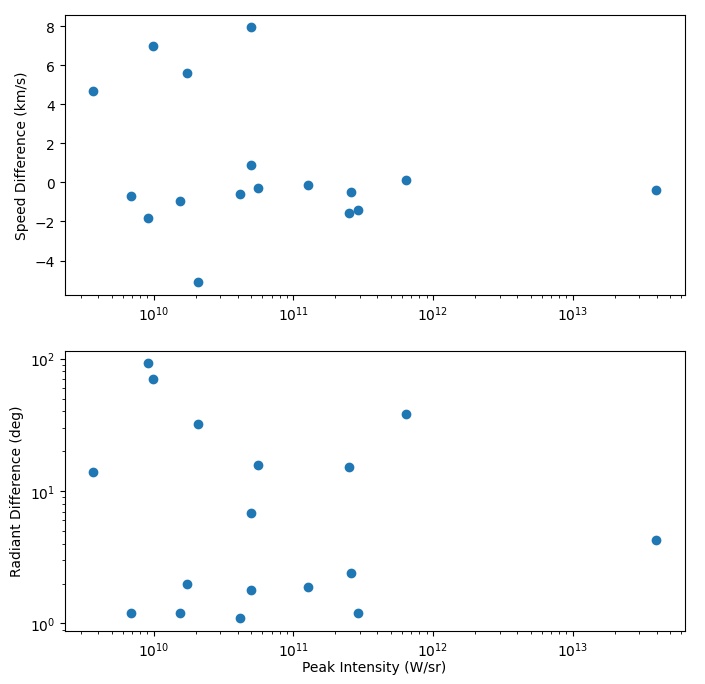

In [11]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(peak_intensities, dv)
# radiant diff
ax2.scatter(peak_intensities, drad)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# set logarithmic x scales for intensity for both
ax1.set_xscale('log')
ax2.set_xscale('log')
# label
ax.set_xlabel('Peak Intensity (W/sr)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()
plt.savefig('error_correlation_plots/peak_intensity.png')

Speed and Radiant differences vs. LC duration:

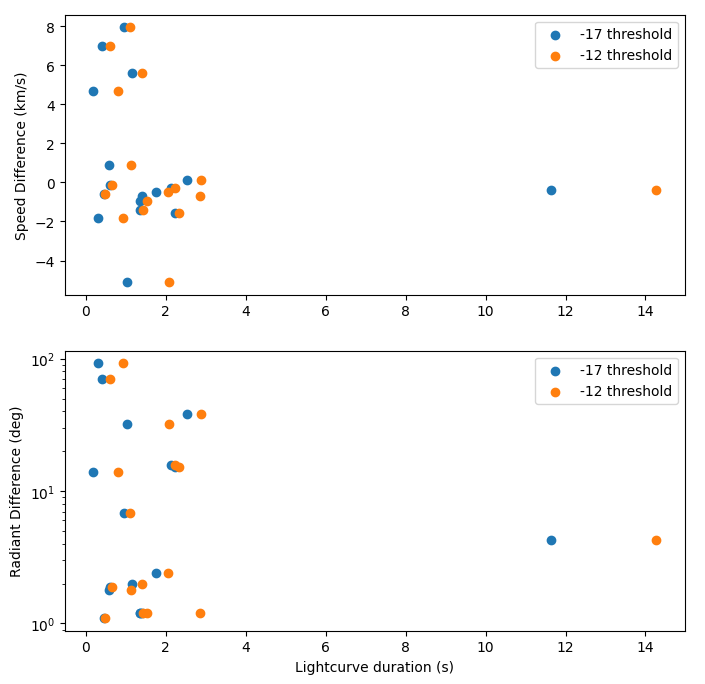

In [12]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(lc_durations_17, dv, label = '-17 threshold')
ax1.scatter(lc_durations_12, dv, label = '-12 threshold')
# radiant diff
ax2.scatter(lc_durations_17, drad, label = '-17 threshold')
ax2.scatter(lc_durations_12, drad, label = '-12 threshold')
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Lightcurve duration (s)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
# plt.tight_layout()
plt.savefig('error_correlation_plots/duration.png')

Now plot the speed and radiant difference vs. the entry angle, colour-coding by duration, peak intensity, total energy (integrated intensity), and height of peak brightness respectively (for a total of $8$ plots):

Define function to compute the total energy (integrated intensity):

In [13]:
def get_total_energy(intensity_csv_path):
    """
    Gets the total energy of a fireball event from the intensity CSV generated by the CNEOS_LC_INT_MAY-format.py 
    script by numerically integrating over intensity, given the path 'intensity_csv_path' to the event

    param str: intensity_csv_path: file path to the intensity CSV for the fireblal event

    return float: returns peak intensity value as a float
    """
    intensity_df = pd.read_csv(intensity_csv_path, header=None, names=['Time (s)', 'Intensity (W/sr)'])  # reading the intensity data
    # numerically integrate over the intensity to get total energy using the trapezoid rule, since we have a dataframe of 
    # times and intensities at the time
    # only take the positive intensities since negative intensities are unphysical
    # could remove some of this code if it slows it down a lot later...
    positive_intensity_df = intensity_df.copy()
    negative_intensity_df = intensity_df.copy()
    # split into positive and negative areas separately
    positive_intensity_df['Intensity (W/sr)'].clip(lower=0., inplace=True)  # ignore negative intensities
    negative_intensity_df['Intensity (W/sr)'].clip(upper=0., inplace=True)  # ignore positive intensities here
    # perform numerical integration over the total intensity using scipy.integrate.trapezoid (trapezoid rule) to get the total energy
    total_energy = scipy.integrate.trapezoid(y=positive_intensity_df['Intensity (W/sr)'], x=positive_intensity_df['Time (s)'])
    # return the total energy
    return total_energy

Get the integrated intensities (total energies) from the fireball `.csv` intensity files: 

In [14]:
integrated_intensities = np.array([get_total_energy(csv_file) for csv_file in int_files])

Getting the entry angles and heights of peak brightness:

In [15]:
# zenith/entry angles
zenith_angle = usg_ground_based_comparison['Radiant Zenith Angle']
entry_angle = 90 - zenith_angle  # entry angle is 90 degrees minus the radiant zenith angle
# heights of peak brightness
heights = usg_ground_based_comparison['Height']

Now plotting speed and radiant difference vs entry angle, colour-coding by duration at $\geq -17$ magnitude, peak intensity, total energy and height of peak brightness. Take $\log_{10}$ of duration, peak intensity, and total energy to scale the colourbar better:

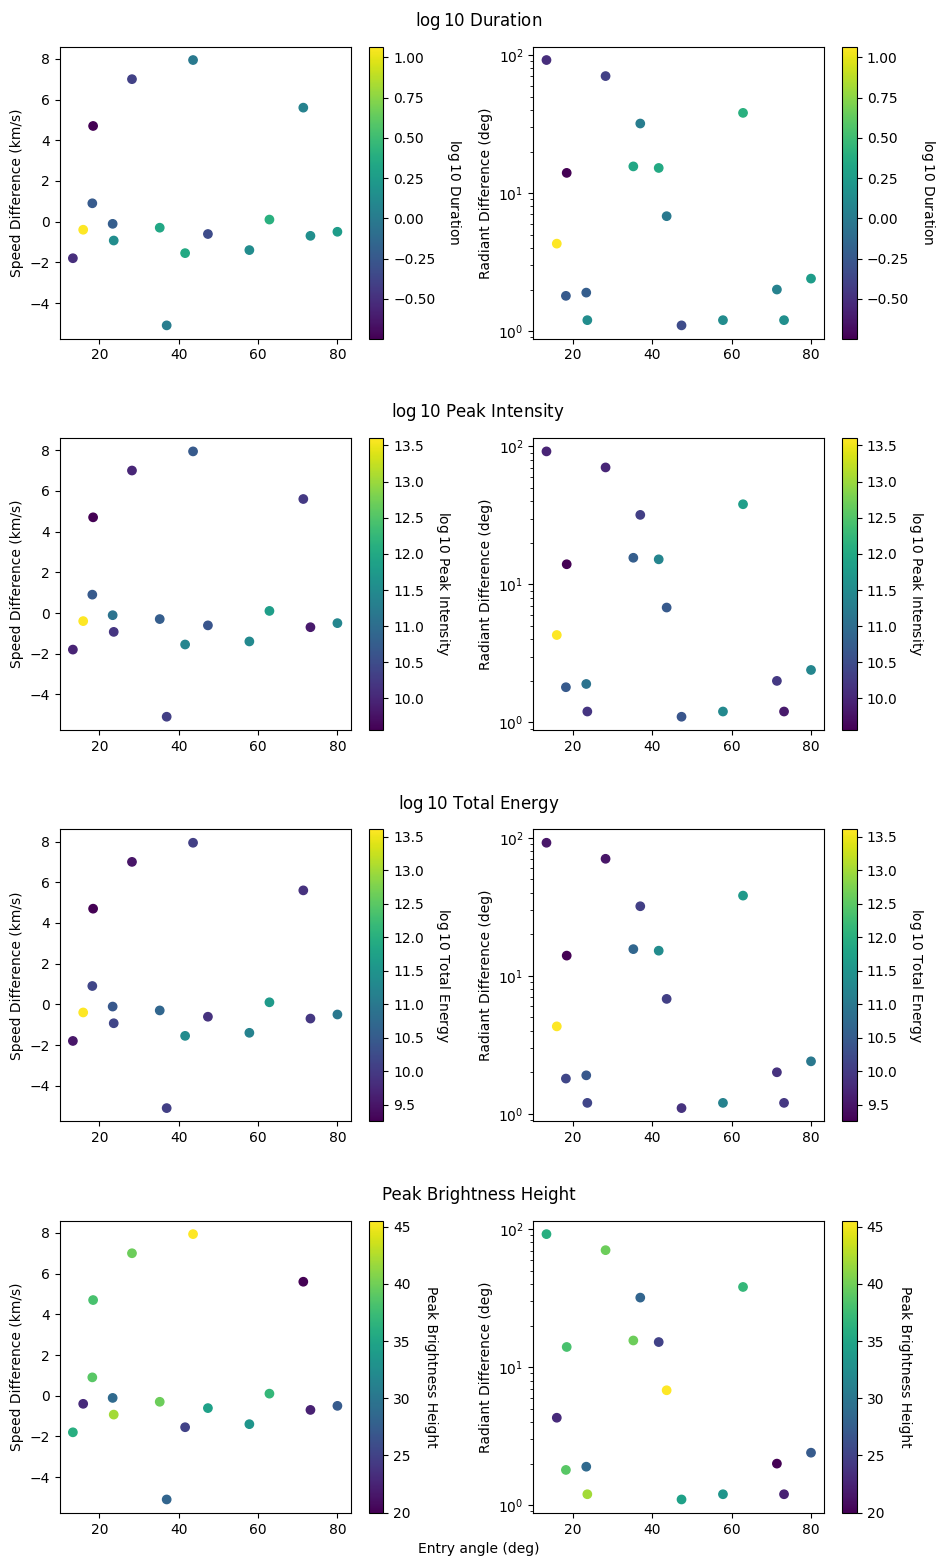

In [16]:
fig = plt.figure(figsize = (10, 16))
# make the big subplots to put labels on
ax_big1 = fig.add_subplot(411)
ax_big2 = fig.add_subplot(412)
ax_big3 = fig.add_subplot(413)
ax_big4 = fig.add_subplot(414)
# make the small plots to actually plot on
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)
# Turn off the axis lines and ticks of the big subplots
ax_big1.spines['top'].set_color('none')
ax_big1.spines['bottom'].set_color('none')
ax_big1.spines['left'].set_color('none')
ax_big1.spines['right'].set_color('none')
ax_big1.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big2.spines['top'].set_color('none')
ax_big2.spines['bottom'].set_color('none')
ax_big2.spines['left'].set_color('none')
ax_big2.spines['right'].set_color('none')
ax_big2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big3.spines['top'].set_color('none')
ax_big3.spines['bottom'].set_color('none')
ax_big3.spines['left'].set_color('none')
ax_big3.spines['right'].set_color('none')
ax_big3.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big4.spines['top'].set_color('none')
ax_big4.spines['bottom'].set_color('none')
ax_big4.spines['left'].set_color('none')
ax_big4.spines['right'].set_color('none')
ax_big4.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff against entry angle, colour-coding by duration, peak intensity, total energy and height of peak brightness
p1 = ax1.scatter(entry_angle, dv, c=np.log10(lc_durations_17), cmap='viridis')  # duration
p3 = ax3.scatter(entry_angle, dv, c=np.log10(peak_intensities), cmap='viridis') # peak intensity
p5 = ax5.scatter(entry_angle, dv, c=np.log10(integrated_intensities), cmap='viridis')  # total energy
p7 = ax7.scatter(entry_angle, dv, c=heights, cmap='viridis')  # height of peak brightness
# radiant diff against entry angle, colour-coding by duration, peak intensity, total energy and height of peak brightness
p2 = ax2.scatter(entry_angle, drad, c=np.log10(lc_durations_17), cmap='viridis')  # duration
p4 = ax4.scatter(entry_angle, drad, c=np.log10(peak_intensities), cmap='viridis')  # peak intensity
p6 = ax6.scatter(entry_angle, drad, c=np.log10(integrated_intensities), cmap='viridis')  # total energy
p8 = ax8.scatter(entry_angle, drad, c=heights, cmap='viridis')  # height of peak brightness
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
ax4.set_yscale('log')
ax6.set_yscale('log')
ax8.set_yscale('log')
# colourbars for each of the plots
cbar1 = fig.colorbar(p1, ax=ax1)
cbar2 = fig.colorbar(p2, ax=ax2)
cbar1.ax.set_ylabel(r'$\log{10}$ Duration', rotation=270)
cbar2.ax.set_ylabel(r'$\log{10}$ Duration', rotation=270)
cbar1.ax.get_yaxis().labelpad=20
cbar2.ax.get_yaxis().labelpad=20
cbar3 = fig.colorbar(p3, ax=ax3)
cbar4 = fig.colorbar(p4, ax=ax4)
cbar3.ax.set_ylabel(r'$\log{10}$ Peak Intensity', rotation=270)
cbar4.ax.set_ylabel(r'$\log{10}$ Peak Intensity', rotation=270)
cbar3.ax.get_yaxis().labelpad=20
cbar4.ax.get_yaxis().labelpad=20
cbar5 = fig.colorbar(p5, ax=ax5)
cbar6 = fig.colorbar(p6, ax=ax6)
cbar5.ax.set_ylabel(r'$\log{10}$ Total Energy', rotation=270)
cbar6.ax.set_ylabel(r'$\log{10}$ Total Energy', rotation=270)
cbar5.ax.get_yaxis().labelpad=20
cbar6.ax.get_yaxis().labelpad=20
cbar7 = fig.colorbar(p7, ax=ax7)
cbar8 = fig.colorbar(p8, ax=ax8)
cbar7.ax.set_ylabel('Peak Brightness Height', rotation=270)
cbar8.ax.set_ylabel('Peak Brightness Height', rotation=270)
cbar7.ax.get_yaxis().labelpad=20
cbar8.ax.get_yaxis().labelpad=20

# label
ax_big1.set_title('$\log{10}$ Duration', pad=15)
# ax_big1.set_xlabel('Entry angle (deg)')
ax_big2.set_title('$\log{10}$ Peak Intensity', pad=15)
# ax_big2.set_xlabel('Entry angle (deg)')
ax_big3.set_title('$\log{10}$ Total Energy', pad=15)
# ax_big3.set_xlabel('Entry angle (deg)')
ax_big4.set_title('Peak Brightness Height', pad=15)
ax_big4.set_xlabel('Entry angle (deg)')
ax1.set_ylabel('Speed Difference (km/s)')
ax3.set_ylabel('Speed Difference (km/s)')
ax5.set_ylabel('Speed Difference (km/s)')
ax7.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
ax4.set_ylabel('Radiant Difference (deg)')
ax6.set_ylabel('Radiant Difference (deg)')
ax8.set_ylabel('Radiant Difference (deg)')
plt.tight_layout()
plt.savefig('error_correlation_plots/entry_angle.png')

Plot speed difference and radiant difference against trajectory length, begin height and end height:

In [17]:
lengths = usg_ground_based_comparison['Length (km)']
begin_heights = usg_ground_based_comparison['Begin Height (km)']
end_heights = usg_ground_based_comparison['End Height (km)']

Length:

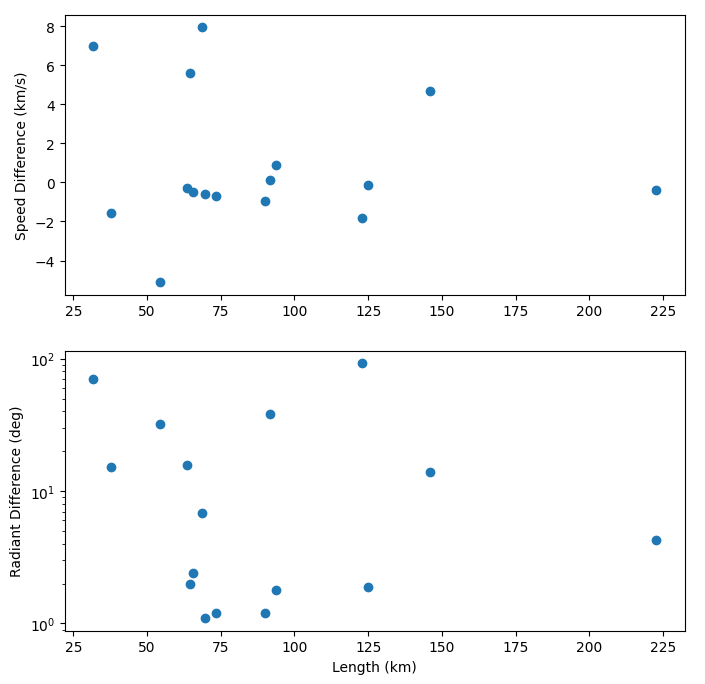

In [18]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(lengths, dv)
# radiant diff
ax2.scatter(lengths, drad)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Length (km)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()
plt.savefig('err-r_correlation_plots/trail_length.png')

Begin/end height:

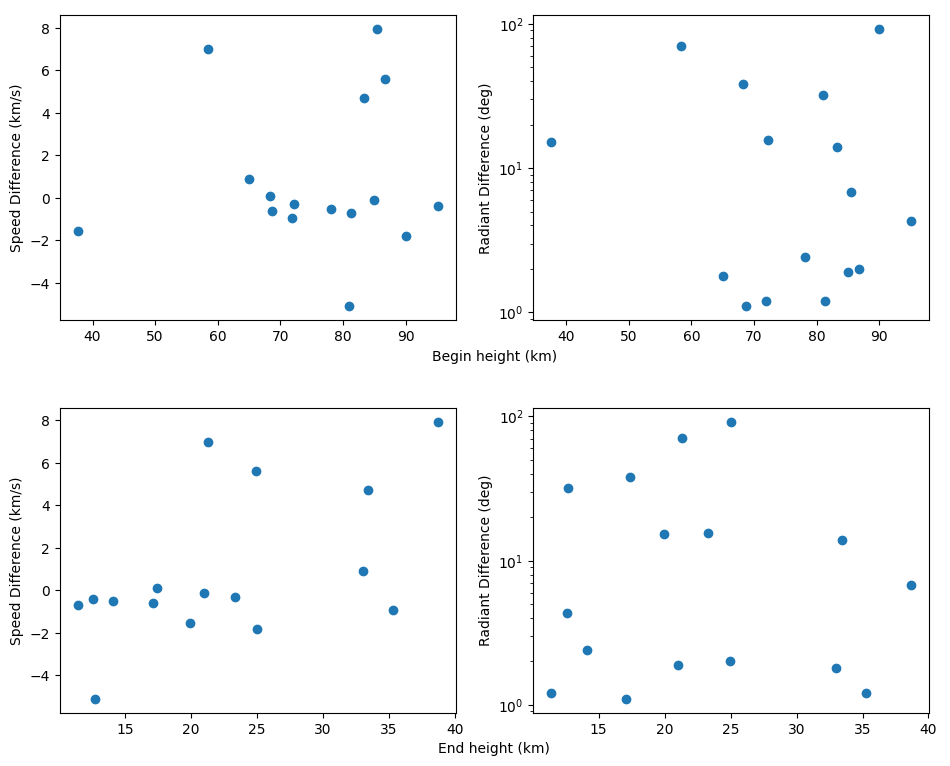

In [19]:
fig = plt.figure(figsize = (10, 8))
# make subplots
ax_big1 = fig.add_subplot(211)    # The big subplot
ax_big2 = fig.add_subplot(212)   # big suplot 2
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# Turn off axis lines and ticks of the big subplots
ax_big1.spines['top'].set_color('none')
ax_big1.spines['bottom'].set_color('none')
ax_big1.spines['left'].set_color('none')
ax_big1.spines['right'].set_color('none')
ax_big1.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big2.spines['top'].set_color('none')
ax_big2.spines['bottom'].set_color('none')
ax_big2.spines['left'].set_color('none')
ax_big2.spines['right'].set_color('none')
ax_big2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff against begin/end heights
ax1.scatter(begin_heights, dv)  # begin
ax3.scatter(end_heights, dv)  # end
# radiant diff against begin/end heights
ax2.scatter(begin_heights, drad)  # begin
ax4.scatter(end_heights, drad)  # end
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
ax4.set_yscale('log')
# label
ax_big1.set_xlabel('Begin height (km)')
ax_big2.set_xlabel('End height (km)')
ax1.set_ylabel('Speed Difference (km/s)')
ax3.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
ax4.set_ylabel('Radiant Difference (deg)')
plt.tight_layout()
plt.savefig('error_correlation_plots/begin_end_height.png')

Now plot speed and radiant difference against event date:

Get dates:

In [20]:
dates = usg_ground_based_comparison['Date']  # convert data to datetime

Plot:

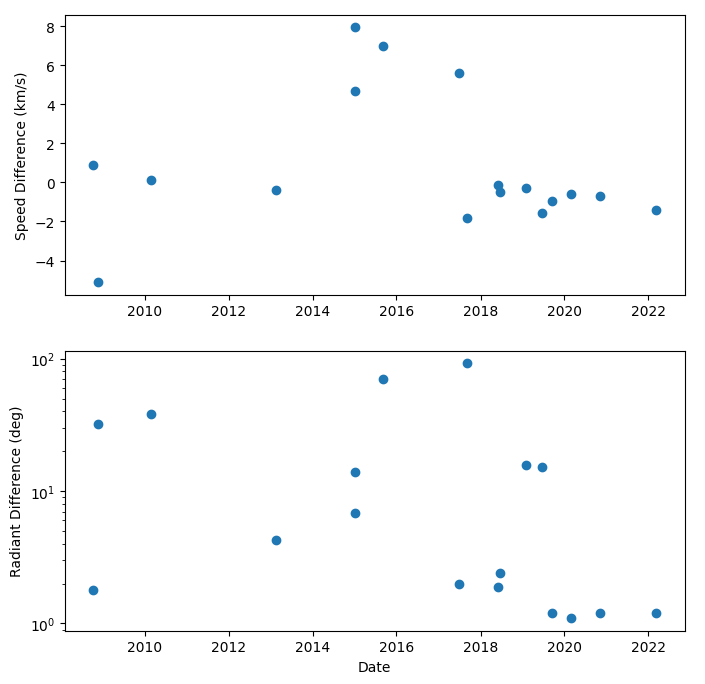

In [21]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(dates, dv)
# radiant diff
ax2.scatter(dates, drad)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Date')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()
plt.savefig('error_correlation_plots/date.png')

Plot CDF/histogram of the radiant/speed differences:

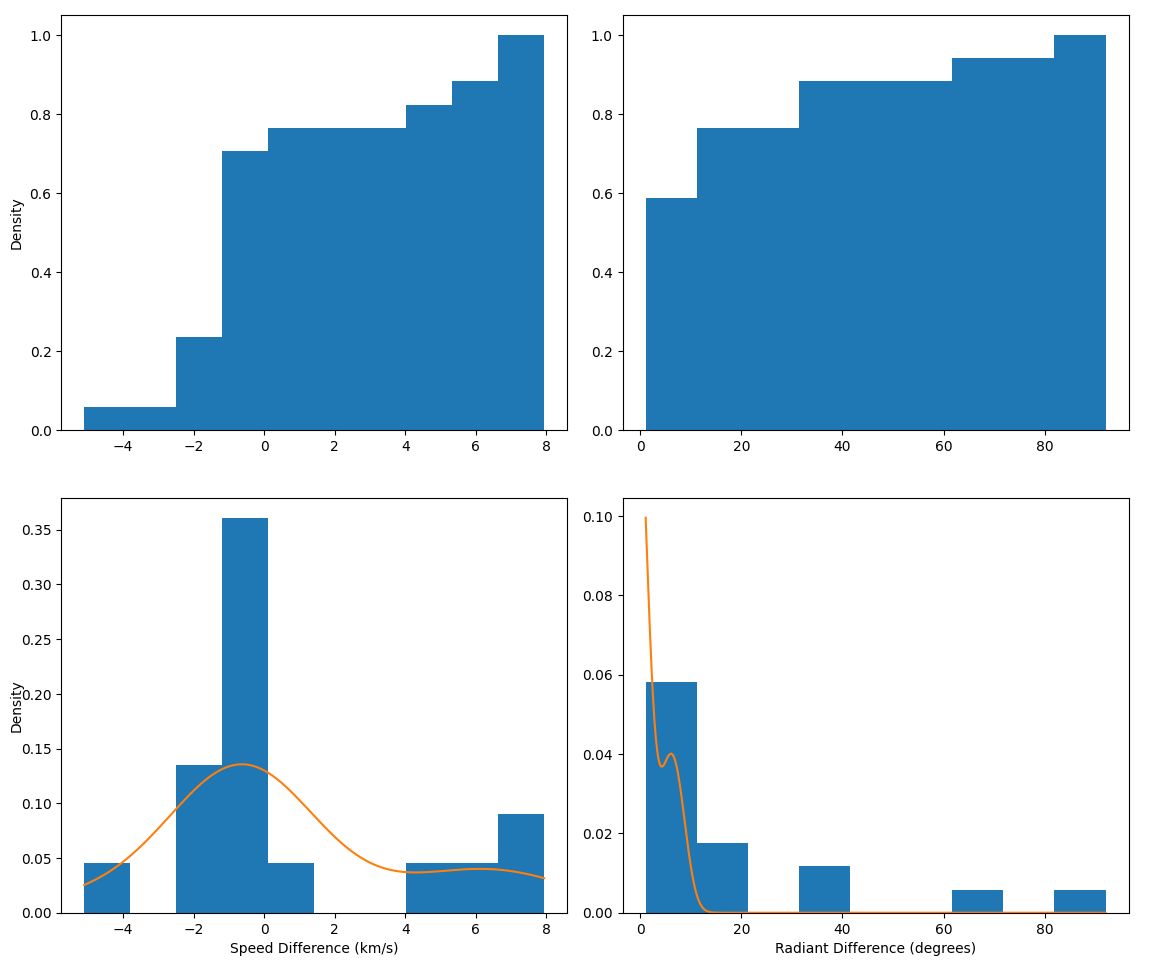

In [22]:
fig = plt.figure(figsize = (12, 10))
# subplots
ax_big1 = fig.add_subplot(211)  # big
ax_big2 = fig.add_subplot(212)  # big
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# Turn off axis lines and ticks of the big subplot
ax_big1.spines['top'].set_color('none')
ax_big1.spines['bottom'].set_color('none')
ax_big1.spines['left'].set_color('none')
ax_big1.spines['right'].set_color('none')
ax_big1.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big2.spines['top'].set_color('none')
ax_big2.spines['bottom'].set_color('none')
ax_big2.spines['left'].set_color('none')
ax_big2.spines['right'].set_color('none')
ax_big2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# plot CDF for dv
ax1.hist(dv, density=True, cumulative=True, bins='fd')
# plot CDF for radiant diff
ax2.hist(drad, density=True, cumulative=True, bins='fd')
# plot histogram for dv
ax3.hist(dv, density=True, bins='fd')  # fd bins?
ax3.plot(np.linspace(np.min(dv), np.max(dv), 1000), scipy.stats.gaussian_kde(dv)(np.linspace(np.min(dv), np.max(dv), 1000)))
# plot for radiant diff
ax4.hist(drad, density=True, bins='fd')  # fd bins?
ax4.plot(np.linspace(np.min(drad), np.max(drad), 1000), scipy.stats.gaussian_kde(dv)(np.linspace(np.min(drad), np.max(drad), 1000)))
# labels
ax_big1.set_ylabel('Density')
ax_big2.set_ylabel('Density')
ax3.set_xlabel('Speed Difference (km/s)')
ax4.set_xlabel('Radiant Difference (degrees)')
plt.tight_layout()

#### Dimensionality reduction:

Now make a dataframe for $X$ that has all the parameters we want to use in our dimensionality reduction methods (PCA, t-SNE/UMAP), which are:

- Speed
- Peak Intensity
- LC Duration
- Total Energy (integrated intensity)
- Entry Angle
- Height of peak brightness
- Trail length
- Begin Height
- End Height
- Date

And a dataframe for $Y$ which is what we want to predict; speed difference and radiant difference

Also drop $2022$ EB$5$ as it contains NaN value:

In [23]:
# dataframe with all the parameters
x_df = pd.concat([usg_ground_based_comparison[['Speed', 'Height', 'Date', 
                                               'Begin Height (km)', 'End Height (km)', 'Length (km)']].reset_index(drop=True), 
                 pd.DataFrame.transpose(pd.DataFrame(data=(peak_intensities, lc_durations_17, integrated_intensities, entry_angle)))], axis=1)
# set column names as variables
variables = ['Speed', 'Height', 'Date', 'Begin Height', 'End Height', 'Length', 'Peak Intensity', 'Duration', 'Total Energy', 'Entry Angle']
x_df.columns = [variables]

# convert date to log number of seconds after the first event
x_df['Date'] = x_df['Date'].astype(int)  

# x_df['Date'] = np.log10(x_df['Date']) # otherwise pca dominated by date
# # convert peak intensities, total energy to log10 as well
# x_df['Peak Intensity'] = np.log10(x_df['Peak Intensity'])
# x_df['Total Energy'] = np.log10(x_df['Total Energy'])
# # convert begin height, end height, length
# x_df['Begin Height'] = x_df['Begin Height'] - np.min(x_df['Begin Height'])
# x_df['End Height'] = x_df['End Height'] - np.min(x_df['End Height'])
# x_df['Length'] = x_df['Length'] - np.min(x_df['Length'])

# define y df
y_df = usg_ground_based_comparison[['DV', 'Radiant Diff']].reset_index(drop=True)

# drop 2022 EB5 as it contains NA value

# x_df.drop(np.reshape(np.where(usg_ground_based_comparison['Event'].str.contains('2022 EB5')), -1), inplace=True)
x_df.drop(x_df[usg_ground_based_comparison.reset_index(drop=True)['Event'] == '2022 EB5'].index, inplace=True)
# y_df.drop(np.reshape(np.where(usg_ground_based_comparison['Event'].str.contains('2022 EB5')), -1), inplace=True)
y_df.drop(y_df[usg_ground_based_comparison.reset_index(drop=True)['Event'] == '2022 EB5'].index, inplace=True)

# transpose, since we want each row to be a variable and each column to be an observation
x_df_transpose = pd.DataFrame.transpose(x_df)

Try manually standardizing the data:

In [24]:
standardized_pca_array = []
standardization_means = np.zeros(len(np.array(x_df_transpose)))
standardization_sigmas = np.zeros(len(np.array(x_df_transpose)))

for i, param in enumerate(np.array(x_df_transpose)):
    mean, sigma = np.mean(param), np.std(param)
    norm = (param - mean)/sigma
    standardized_pca_array.append(norm)
    standardization_means[i] = mean
    standardization_sigmas[i] = sigma

Performing the PCA (scaling data first):

In [25]:
# scaling
standardized_pca_array = StandardScaler().fit_transform(standardized_pca_array)

# perform PCA
pca = PCA(n_components = 4)
all_pca = pca.fit_transform(standardized_pca_array)

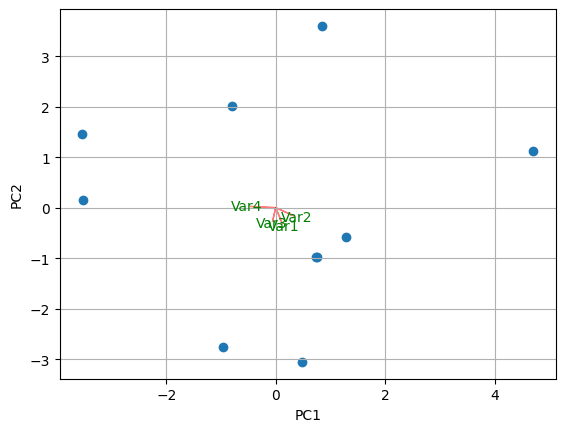

In [26]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs,ys) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(all_pca, pca.components_) 
plt.show()

In [27]:
all_pca, variables

(array([[-0.80528144,  2.01182897, -0.80700552,  0.77123394],
        [-3.53462726,  1.45889758, -1.75470401,  0.56084579],
        [ 0.84930141,  3.6017908 ,  3.71723253, -0.88649469],
        [ 0.48339884, -3.05532927,  2.00788773,  2.00058133],
        [-3.52285132,  0.14684046, -0.07191156,  0.59078589],
        [-0.96222987, -2.75949696,  1.36442049, -0.57340653],
        [ 0.75498111, -0.97709546, -0.8131344 , -1.30953715],
        [ 1.28754262, -0.57326756, -1.3614438 , -1.50070124],
        [ 0.74248462, -0.97004633, -0.80345452, -1.31347931],
        [ 4.70728128,  1.11587777, -1.47788694,  1.66017197]]),
 ['Speed',
  'Height',
  'Date',
  'Begin Height',
  'End Height',
  'Length',
  'Peak Intensity',
  'Duration',
  'Total Energy',
  'Entry Angle'])

In [28]:
pca.explained_variance_ratio_

array([0.32731854, 0.24743551, 0.1799431 , 0.09264851])

Doesn't look like there's anything that particularly stands out as being very important...

PC1: Height, End Height, Entry Angle as highest contributors to variance...

PC2: Date, Begin Height, Length (pretty weak...)

Try UMAP/t-SNE next:

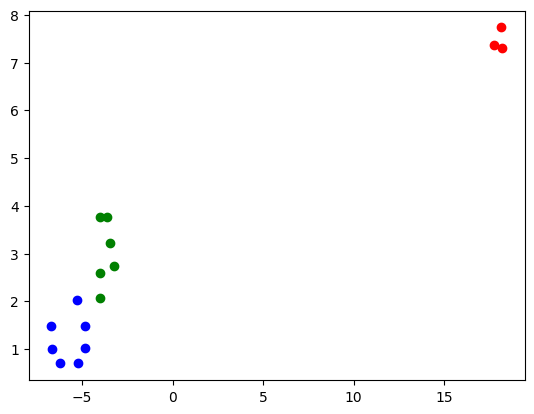

In [29]:
# umap takes in the array transposed
standardized_pca_array_transpose = np.transpose(standardized_pca_array)

# perfrom the reduction and UMAP
reducer = umap.UMAP(n_neighbors=3, n_components=2)
embedding = reducer.fit_transform(standardized_pca_array_transpose)

umap_dimX = embedding[:, 0]
umap_dimY = embedding[:, 1]

# empirically determined clusters?
indices_g1 = [2, 7, 12]
indices_g2 = [0, 6, 11, 13, 14, 15]
indices_g3 = [1, 3, 4, 5, 8, 9, 10]

# plot
# plt.scatter(umap_dimX, umap_dimY)#, s=1)
plt.scatter(umap_dimX[indices_g1], umap_dimY[indices_g1], c='r')
plt.scatter(umap_dimX[indices_g2], umap_dimY[indices_g2], c='g')
plt.scatter(umap_dimX[indices_g3], umap_dimY[indices_g3], c='b')

Green and blue not necessarily so distinct all the time, red is though...

In [30]:
usg_ground_based_comparison_dimred = usg_ground_based_comparison.reset_index(drop=True).drop(usg_ground_based_comparison.reset_index(drop=True)[usg_ground_based_comparison.reset_index(drop=True)['Event'] == '2022 EB5'].index).reset_index(drop=True)

names = usg_ground_based_comparison_dimred ['Event']
names[indices_g1], names[indices_g2], names[indices_g3]

(2     Baird Bay
 7     Froslunda
 12      Ozerski
 Name: Event, dtype: object,
 0         2019MO
 6      Flensburg
 11    Novo Mesto
 13       Romania
 14     Sariçiçek
 15       Vinales
 Name: Event, dtype: object,
 1     Almahata Sitta 
 3     Buzzard Coulee 
 4        Chelyabinsk 
 5        Crawford Bay
 8            Kalabity
 9             Kosice 
 10        Motopi Pan 
 Name: Event, dtype: object)

BB, Froslunda, Ozerski are the most distinct cluster in all of these...

In [31]:
x_df.iloc[indices_g1][variables]

,Speed,Height,Date,Begin Height,End Height,Length,Peak Intensity,Duration,Total Energy,Entry Angle
3,15.2,20.0,1498780800000000000,86.782,24.957811,64.718506,1.730000e+10,1.148,7.633731e+09,71.4
8,16.7,22.3,1604707200000000000,81.300,11.400000,73.455665,6.870000e+09,1.410,9.169055e+09,73.2
13,14.4,27.2,1529539200000000000,78.133,14.103000,65.560000,2.600000e+11,1.769,9.873937e+10,80.0


In [32]:
y_df.iloc[indices_g1]

,DV,Radiant Diff
3,5.6,2.0
8,-0.7,1.2
13,-0.5,2.4


#### Constructing a smooth distribution for the data:

Try fitting a parametric Gaussian distribution first:

Bootstrap the data:

In [33]:
seed = 1234

# speed uncertatinty
dv_bootstrap_mean = scipy.stats.bootstrap((np.array(dv), ), np.mean, random_state=np.random.seed(seed))
dv_bootstrap_stdev = scipy.stats.bootstrap((np.array(dv), ), np.std, random_state=np.random.seed(seed))

# radiant uncertainty
drad_bootstrap_mean = scipy.stats.bootstrap((np.array(drad), ), np.mean, random_state=np.random.seed(seed))
drad_bootstrap_stdev = scipy.stats.bootstrap((np.array(drad), ), np.std, random_state=np.random.seed(seed))

Parametric density estimation with normal distribution:

In [34]:
dv_dist = scipy.stats.norm(np.median(dv_bootstrap_mean.bootstrap_distribution), np.std(dv_bootstrap_stdev.bootstrap_distribution))
drad_dist = scipy.stats.norm(np.median(drad_bootstrap_mean.bootstrap_distribution), np.std(drad_bootstrap_mean.bootstrap_distribution))

(array([0.04511007, 0.        , 0.13533021, 0.36088055, 0.04511007,
        0.        , 0.        , 0.04511007, 0.04511007, 0.09022014]),
 array([-5.1  , -3.796, -2.492, -1.188,  0.116,  1.42 ,  2.724,  4.028,
         5.332,  6.636,  7.94 ]),
 <BarContainer object of 10 artists>)

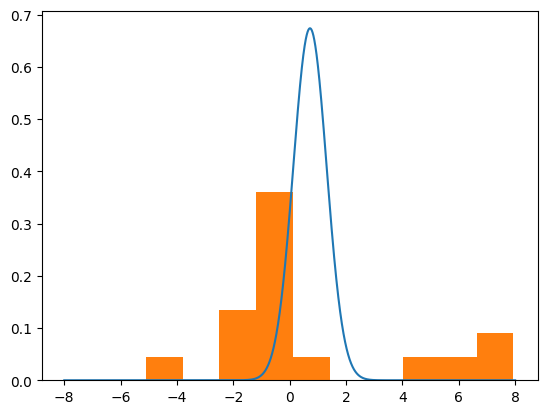

In [35]:
values_dv = np.linspace(-8, 8, int(1e4))
plt.plot(values_dv, np.array([dv_dist.pdf(value) for value in values_dv]))
plt.hist(dv, density=True)

Doesn't look like it matches very well... could try some transformation or could try nonparametric

Construct nonparametric Gaussian KDE for speed difference and plot:

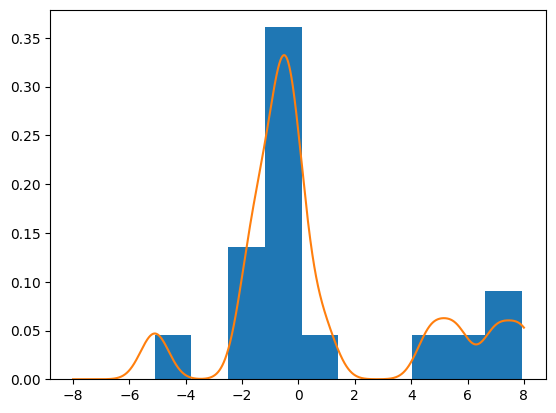

In [36]:
kde_dv = np.array(dv).reshape((len(dv), 1))
kde_values_dv = values_dv.reshape(len(values_dv), 1)

# bandwidith for KDE, could change this...
bandwidth = 0.5
kde_model_dv = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde_model_dv.fit(kde_dv)
plt.hist(dv, density=True, bins='auto')
plt.plot(kde_values_dv, np.exp(kde_model_dv.score_samples(kde_values_dv)))

Compare a bunch of different bandwidths:

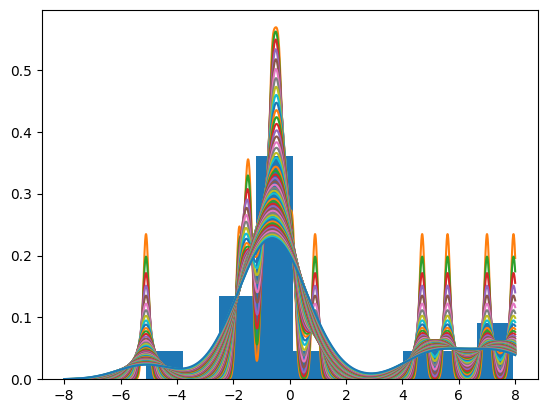

In [37]:
plt.hist(dv, density=True, bins='fd')

bandwidths = np.linspace(0.1, 1., 50)

for bandwidth in bandwidths:
    kde_model_dv = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde_model_dv.fit(kde_dv)
    plt.plot(kde_values_dv, np.exp(kde_model_dv.score_samples(kde_values_dv)))

`fd` or `auto` bins produce histogram that visually works best with something like $0.5$ bandwidth, `doane` and `sturges` bins produce histograms that visually work best with something like $1$ bandwidth...

probably want something in between $0.5$ and $1$ in that case

Construct nonparametric KDE for log-radiant difference and plot:

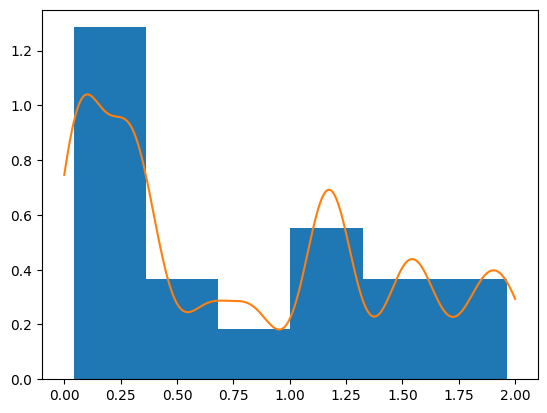

In [38]:
log_drad = np.log10(drad)
values_drad = np.linspace(0., 2., 1000)

kde_log_drad = np.array(log_drad).reshape((len(log_drad), 1))
kde_values_log_drad = values_drad.reshape(len(values_drad), 1)

# kde
bandwidth = 0.1
kde_model_log_drad = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde_model_log_drad.fit(kde_log_drad)

plt.hist(log_drad, density=True, bins='auto')
plt.plot(kde_values_log_drad, np.exp(kde_model_log_drad.score_samples(kde_values_log_drad)))

something like $0.1$ bandwidth with `auto` or `sturges`? `fd` seems to produce pretty bad plot that is mostly flat..